In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Historical data Download
securities = [
    "HDFCBANK.NS", "RELIANCE.NS", "INFY.NS", "TCS.NS",
    "ICICIBANK.NS", "LT.NS", "BHARTIARTL.NS", "HINDUNILVR.NS"
]

data = yf.download(securities, start="2005-01-01", end="2026-02-14")["Close"]


[*********************100%***********************]  8 of 8 completed


In [3]:
#Calculate Return
returns = data.pct_change().dropna()

In [4]:
# Assigning Weights to Securities
weights = pd.Series({
    "HDFCBANK.NS": 0.10,
    "RELIANCE.NS": 0.10,
    "INFY.NS": 0.15,
    "TCS.NS": 0.10,
    "ICICIBANK.NS": 0.15,
    "LT.NS": 0.10,
    "BHARTIARTL.NS": 0.15,
    "HINDUNILVR.NS": 0.15
})

In [5]:
investment = 1_000_000
invest_per_security = weights * investment
invest_per_security

HDFCBANK.NS      100000.0
RELIANCE.NS      100000.0
INFY.NS          150000.0
TCS.NS           100000.0
ICICIBANK.NS     150000.0
LT.NS            100000.0
BHARTIARTL.NS    150000.0
HINDUNILVR.NS    150000.0
dtype: float64

In [6]:
current_price = data.iloc[-1]
current_price

Ticker
BHARTIARTL.NS    2004.699951
HDFCBANK.NS       903.900024
HINDUNILVR.NS    2305.199951
ICICIBANK.NS     1414.599976
INFY.NS          1369.099976
LT.NS            4173.899902
RELIANCE.NS      1419.599976
TCS.NS           2692.199951
Name: 2026-02-13 00:00:00, dtype: float64

In [7]:
shares = (invest_per_security/current_price).round(0)
shares

BHARTIARTL.NS     75.0
HDFCBANK.NS      111.0
HINDUNILVR.NS     65.0
ICICIBANK.NS     106.0
INFY.NS          110.0
LT.NS             24.0
RELIANCE.NS       70.0
TCS.NS            37.0
dtype: float64

In [8]:
# Scenario shock function
def scenario_shock(returns, start, end):
    window = returns.loc[start:end]
    shock = (1 + window).prod() - 1
    return shock

In [9]:
# Historical stress scenarios
GFC_2008 = scenario_shock(returns, "2008-01-01", "2009-03-31")
china_2015 = scenario_shock(returns, "2015-08-01", "2016-02-29")
covid_crash = scenario_shock(returns, "2020-02-01", "2020-03-31")
rate_hike_2022 = scenario_shock(returns, "2022-04-01", "2022-12-31")

In [10]:
# Stress loss calculation
def stress_calculation(current_price, shock, shares):
    stressed_price = current_price * (1 + shock)
    portfolio_now = (current_price * shares).sum()
    portfolio_stress = (stressed_price * shares).sum()
    return portfolio_stress - portfolio_now

In [11]:
GFC_2008_loss = stress_calculation(current_price, GFC_2008, shares)
china_2015_loss = stress_calculation(current_price, china_2015, shares)
covid_crash_loss = stress_calculation(current_price, covid_crash, shares)
rate_hike_2022_loss = stress_calculation(current_price, rate_hike_2022, shares)

print("GFC 2008 Loss:", GFC_2008_loss)
print("China 2015 Loss:", china_2015_loss)
print("COVID Crash Loss:", covid_crash_loss)
print("Rate Hike 2022 Loss:", rate_hike_2022_loss)

GFC 2008 Loss: -385194.4497913326
China 2015 Loss: -171840.18433707836
COVID Crash Loss: -183511.5132912048
Rate Hike 2022 Loss: 73238.09204881522


In [12]:
#Scenario Comparison
scenario_table = pd.DataFrame({
    "Scenario": ["GFC 2008", "China 2015", "COVID 2020", "Rate Hike 2022"],
    "Stress Loss": [GFC_2008_loss, china_2015_loss, covid_crash_loss, rate_hike_2022_loss]
})

scenario_table.index = range(1, len(scenario_table) + 1)
scenario_table

,Scenario,Stress Loss
1,GFC 2008,-385194.449791
2,China 2015,-171840.184337
3,COVID 2020,-183511.513291
4,Rate Hike 2022,73238.092049


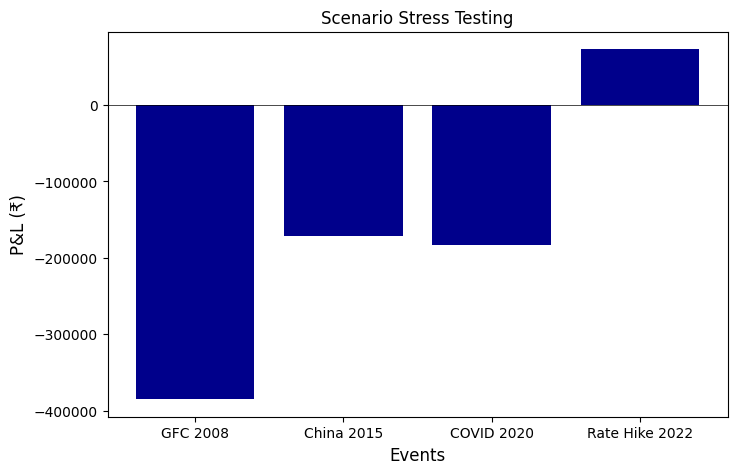

In [13]:
# Plot stress losses
plt.figure(figsize=(8, 5))
plt.bar(scenario_table["Scenario"], scenario_table["Stress Loss"], color = "DarkBlue")
plt.ylabel("P&L (₹)", fontsize=12)
plt.xlabel("Events", fontsize=12)
plt.axhline(0, linewidth=0.5, color= "Black")
plt.title("Scenario Stress Testing")
plt.show()

In [14]:
#Calculation
def stress_loss_table( current_price, shock, shares):
    stress_loss = current_price* (1 + shock)
    pnl = shares * (stress_loss - current_price)

    return pnl

In [15]:
pnl_GFC_2008 = stress_loss_table(current_price, GFC_2008, shares)
pnl_china_2015 = stress_loss_table(current_price, china_2015, shares)
pnl_covid_crash = stress_loss_table(current_price, covid_crash, shares)
pnl_rate_hike_2022 = stress_loss_table(current_price, rate_hike_2022, shares)


In [16]:
#Combine Data For Table
combined_table = pd.DataFrame ({
    "GFC 2008(₹)" : pnl_GFC_2008,
    "GFC 2008(%)" : pnl_GFC_2008/pnl_GFC_2008.sum()*100,
    "China 2015(₹)" : pnl_china_2015,
    "China 2015(%)" : pnl_china_2015/pnl_china_2015.sum()*100,        
    "COVID P&L(₹)" : pnl_covid_crash,
    "COVID(%)" : pnl_covid_crash/pnl_covid_crash.sum()*100,
    "Rate Hike P&L(₹)" : pnl_rate_hike_2022,
    "Rate Hike(%)" : pnl_rate_hike_2022/pnl_rate_hike_2022.sum()*100
    
})
combined_table

,GFC 2008(₹),GFC 2008(%),China 2015(₹),China 2015(%),COVID P&L(₹),COVID(%),Rate Hike P&L(₹),Rate Hike(%)
BHARTIARTL.NS,-55929.522844,14.519815,-36451.302788,21.212328,-16823.619606,9.167610,10900.355250,14.883451
HDFCBANK.NS,-43533.374489,11.301662,-12617.765735,7.342733,-29814.330927,16.246572,12059.631007,16.466337
HINDUNILVR.NS,21477.422948,-5.575735,-13707.864297,7.977101,19464.025706,-10.606433,40398.591513,55.160628
ICICIBANK.NS,-108935.728478,28.280711,-55709.701301,32.419484,-57594.265975,31.384552,34062.286582,46.508976
INFY.NS,-35458.949924,9.205468,2372.822451,-1.380831,-26094.845832,14.219732,-28907.915447,-39.471148
LT.NS,-67714.120783,17.579205,-39383.249899,22.918533,-40197.979341,21.904881,19543.426571,26.684784
RELIANCE.NS,-46534.290112,12.080727,-3491.421386,2.031784,-20970.444535,11.427318,-2988.580175,-4.080636
TCS.NS,-48565.886110,12.608148,-12851.701382,7.478868,-11480.052781,6.255767,-11829.703253,-16.152391


<Figure size 640x480 with 0 Axes>

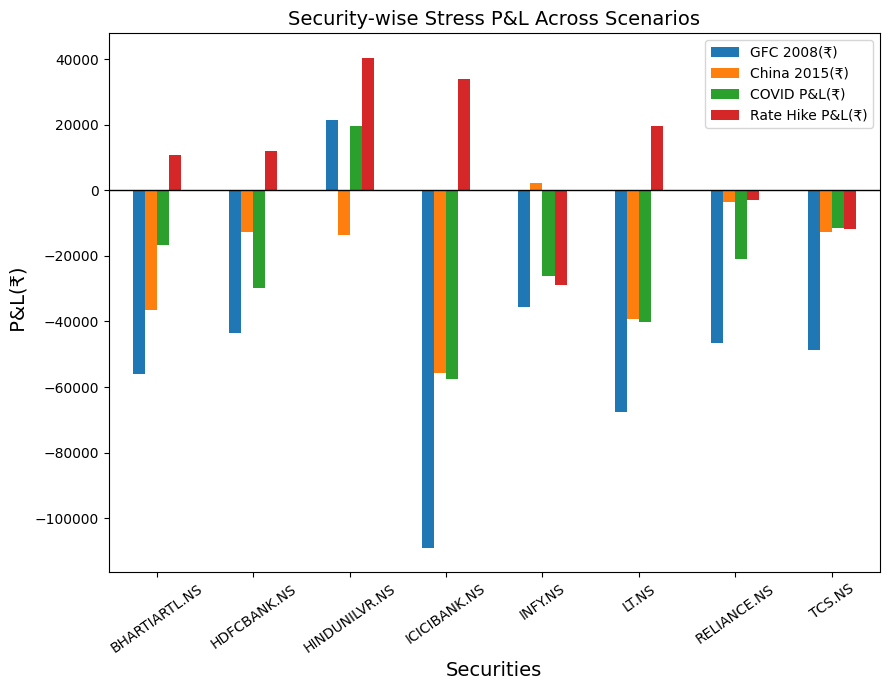

In [17]:
#Stress P&L Scenario
plt.figure()
combined_table[["GFC 2008(₹)", "China 2015(₹)", "COVID P&L(₹)", "Rate Hike P&L(₹)"]].plot(kind = "bar", figsize=(9,7))
plt.ylabel(" P&L(₹)", fontsize = 14)
plt.xlabel("Securities", fontsize = 14)
plt.title("Security-wise Stress P&L Across Scenarios", fontsize = 14)
plt.axhline(0, linewidth = "1", color = "Black")
plt.xticks(rotation = 35)
plt.legend()
plt.tight_layout()
plt.show()

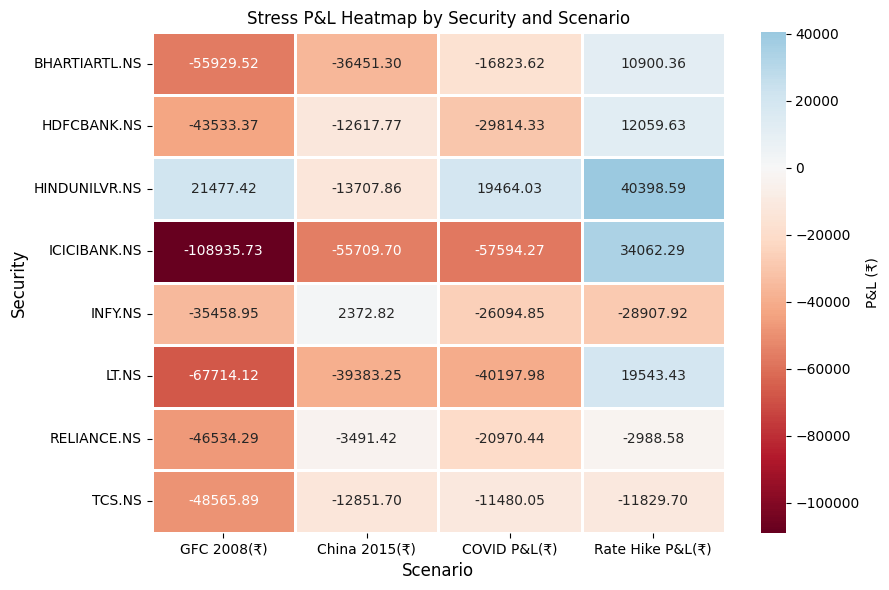

In [18]:
# HeatMap
plt.figure(figsize=(9, 6))

sns.heatmap(
    combined_table[["GFC 2008(₹)", "China 2015(₹)", "COVID P&L(₹)", "Rate Hike P&L(₹)"]],
    annot=True,          
    fmt=".2f",          
    cmap="RdBu",       
    center=0,           
    linewidths=2,
    cbar_kws={"label": "P&L (₹)"},
    
    )

plt.title("Stress P&L Heatmap by Security and Scenario", fontsize = 12)
plt.xlabel("Scenario", fontsize = 12)
plt.ylabel("Security", fontsize = 12)


plt.tight_layout()
plt.show()